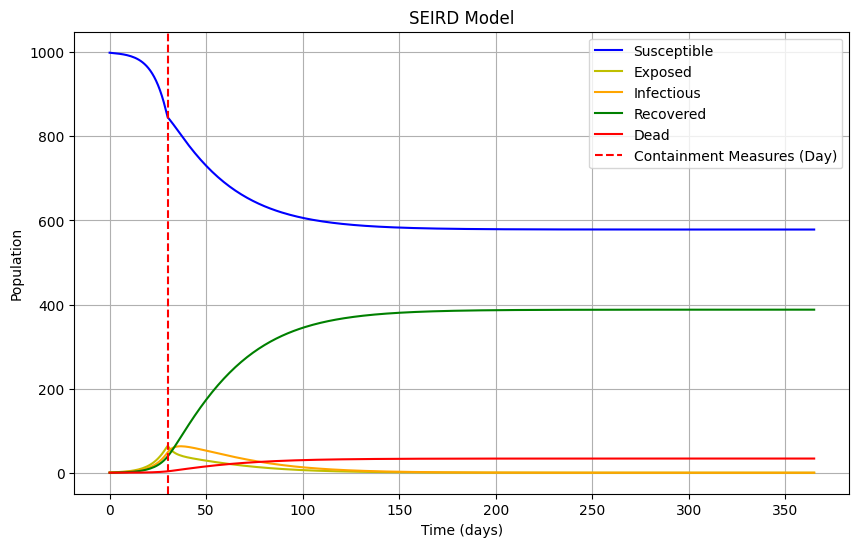

Final susceptible: 578.43
Final exposed: 0.00
Final infectious: 0.00
Final recovered: 387.84
Final deceased: 33.73


In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

# Define the SEIR model
def seird_model(y, t, N, beta, sigma, gamma, delta, healthcare_quality, containment_effectiveness, time_of_containment):
    S, E, I, R, D = y
    if t > time_of_containment:
        beta = beta * containment_effectiveness
    else:
        beta
    
    gamma = gamma * (1 + healthcare_quality)
    
    # differential equations
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

# Initial conditions
N = 1000  # Total population
I0 = 1         # Initial number of infected individuals
E0 = 0         # Initial number of exposed individuals
R0 = 0         # Initial number of recovered individuals
D0 = 0       # Initial dead population
S0 = N - I0 - E0 - R0  # Initial number of susceptible individuals
y0 = S0, E0, I0, R0, D0

# Parameters
beta = 0.5     # Transmission rate
sigma = 1/5.2  # Progression rate (incubation period ~5.2 days)
gamma = 1/10   # Recovery rate (infectious period ~10 days)
delta = 0.01  # Death rate

healthcare_quality = 0.15 # buffs gamma by some scalar value between 0 and 1 (0 = no healthcare, 1 = perfect healthcare) 
containment_effectiveness = 0.25 # debuffs beta by some scalar value between 0 and 1 (0 = perfect containment, 1 = no containment)
time_of_containment = 30

# Time grid (days)
t = np.linspace(0, 365, 365)

# Solve the differential equations
solution = odeint(seird_model, y0, t, args=(N, beta, sigma, gamma, delta, healthcare_quality, containment_effectiveness, time_of_containment))
S, E, I, R, D = solution.T

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', color = 'b')
plt.plot(t, E, label='Exposed', color = 'y')
plt.plot(t, I, label='Infectious', color = 'orange')
plt.plot(t, R, label='Recovered', color = 'g')
plt.plot(t, D, label='Dead', color = 'r')
plt.axvline(x=time_of_containment, color='r', linestyle='--', label='Containment Measures (Day)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.title('SEIRD Model')
plt.grid()
plt.show()

# checking that the final values still sum to N (total population)
total_population = S + E + I + R + D
assert np.allclose(total_population, N), "Population is not conserved!"

# displaying the final values for each piece of the model
print(f"Final susceptible: {S[-1]:.2f}")
print(f"Final exposed: {E[-1]:.2f}")
print(f"Final infectious: {I[-1]:.2f}")
print(f"Final recovered: {R[-1]:.2f}")
print(f"Final deceased: {D[-1]:.2f}")

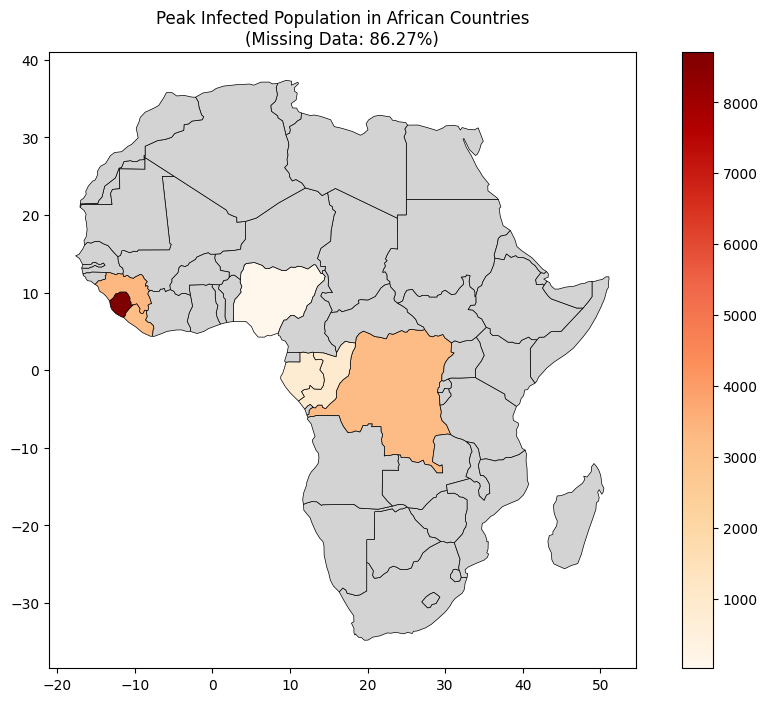

In [9]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from branca.colormap import linear

# Load the shapefile into a GeoDataFrame
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Load in the city data
# cities = gpd.read_file("/Users/JasonHunter/Desktop/ne_110m_populated_places/ne_110m_populated_places.shp")


# Filter out only African countries
africa = world[world['CONTINENT'] == 'Africa']
# cities = cities[cities['ADM0NAME'].isin(africa['ADMIN'])]
# print(cities.head())
# cities_grouped = cities.groupby('NAME')['geometry'].apply(lambda x: x.values.tolist()).reset_index()
# print(cities_grouped.head())



# Check the structure of the GeoDataFrame
# print(africa.head())

seir_results = pd.DataFrame({
    'ADMIN': ['Nigeria', 'Guinea', 'Sierra Leone', 'Liberia', 'Democratic Republic of the Congo', 'Gabon', 'Republic of the Congo'],  # Relevant countries
    'peak_infected': [19, 3351, 8704, 3153, 3250, 807, 950], # these numbers are from the dataset, but also some are from wikipedia
        
})

# Merge SEIR results with GeoDataFrame
africa = africa.merge(seir_results, on='ADMIN', how='left')

missing_count = africa['peak_infected'].isna().sum()
# print(missing_count)
total_count = len(africa)
# print(total_count)
missing_percentage = (missing_count / total_count) * 100

# Plot the map, coloring countries by peak infected
africa.plot(column='peak_infected', cmap='OrRd', legend=True, figsize=(12, 8), missing_kwds={'color': 'lightgrey'}, edgecolor='black', linewidth=0.5)
# plt.title('Peak Infected Population in African Countries')
plt.title(f'Peak Infected Population in African Countries\n(Missing Data: {missing_percentage:.2f}%)')

plt.show()

In [15]:
africa_json = africa.to_crs(epsg=4326).to_json() # epsg=4326 is the WGS84 coordinate system

# Define the color scale
color_scale = linear.YlOrRd_09.scale(africa['peak_infected'].min(), africa['peak_infected'].max())

# create a folium map centered on Africa
m = folium.Map(location=[10, 20], zoom_start=3, tiles = 'cartodbpositron', min_zoom= 2, max_bounds=True)

# add the GeoDataFrame as a choropleth layer
folium.Choropleth(
    geo_data=africa_json,
    data=africa,
    columns=['ADMIN', 'peak_infected'],
    key_on='feature.properties.ADMIN',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Peak Infected Population'
).add_to(m)

folium.GeoJson(
    africa_json,
    style_function=lambda feature: {
        'fillColor': color_scale(feature['properties']['peak_infected']) if feature['properties']['peak_infected'] else 'lightgrey',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    highlight_function=lambda feature: {
        'weight': 3,
        'color': 'blue',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['ADMIN', 'peak_infected'],
        aliases=['Country', 'Peak Infected'],
        localize=True
    )
).add_to(m)
# display the map
m.save("africa_seir_map.html")
m

cities = [
    # Nigeria
    {"name": "Lagos", "coords": [6.5244, 3.3792], "peak_infected": 19},
    {"name": "Port Harcourt", "coords": [4.74974, 6.82766], "peak_infected": 2},
    # Guinea
    {"name": "Gueckedou", "coords": [8.56744, -10.1336], "peak_infected": 11},
    {"name": "Macenta", "coords": [8.54301, -9.47101], "peak_infected": 2},
    {"name": "Kissidougou", "coords": [9.18333, -10.1], "peak_infected": 1},
    {"name": "Conakry", "coords": [9.50917, -13.71222], "peak_infected": 3351},
    # Liberia
    {"name": "Monrovia", "coords": [6.31056, -10.80472], "peak_infected": 3153},
    # Sierra Leone
    {"name": "Kailahun", "coords": [8.2789, -10.573], "peak_infected": 508},
    {"name": "Freetown", "coords": [8.4656, -13.2317], "peak_infected": 'Unknown'},
    {"name": "Kenema", "coords": [7.87687, -11.19025], "peak_infected": 395},
    {"name": "Kono", "coords": [9.1333, -10.8333], "peak_infected": 14},
    {"name": "Kambia", "coords": [9.1258, -12.9763], "peak_infected": 2},
    {"name": "Bombali", "coords": [9.3333, -12.2499] , "peak_infected": 73},
    {"name": "Tonkolili", "coords": [8.6667, -11.6667] , "peak_infected": 26},
    {"name": "Port Loko", "coords": [8.7661, -12.78696] , "peak_infected": 119},
    {"name": "Pujehun", "coords": [7.3333, -11.49998] , "peak_infected": 10},
    {"name": "Bo", "coords": [7.96472, -11.73833] , "peak_infected": 67},
    {"name": "Moyamba", "coords": [8.0, -12.49998] , "peak_infected": 14},
    {"name": "Bonthe", "coords": [7.52639, -12.505] , "peak_infected": 1}
    ]

for city in cities:
    folium.Marker(
        location=city['coords'],
        popup=f"{city['name']}: {city['peak_infected']} peak infections",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)
    
m.save("africa_seir_map.html")
m

In [11]:
file_path = '/Users/JasonHunter/Desktop/ebola-outbreaks-before-2014.xlsx'
df = pd.read_excel(file_path)
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/JasonHunter/Desktop/ebola-outbreaks-before-2014.xlsx'

In [15]:
ebola_data = pd.read_csv("pandemic_ebola_dataset.csv")
ebola_data.head(5)

,Country/Region,Date,Confirmed,Deaths,Lat,Long
0,Guinea,2014-08-29,482.0,287.0,9.945600,-9.696600
1,Nigeria,2014-08-29,15.0,6.0,9.082000,8.675300
2,Sierra Leone,2014-08-29,935.0,380.0,8.460555,-11.779889
3,Liberia,2014-08-29,322.0,225.0,6.428100,-9.429500
4,Sierra Leone,2014-09-05,1146.0,443.0,8.460555,-11.779889


In [16]:
# Number of cases per day

ebola_per_day = ebola_data.groupby('Date')[['Confirmed', 'Deaths']].max()
ebola_per_day

,Confirmed,Deaths
Date,,
2014-08-29,935.0,380.0
2014-09-05,1146.0,443.0
2014-09-08,1234.0,508.0
2014-09-12,1287.0,498.0
2014-09-16,1464.0,563.0
...,...,...
2015-12-17,8704.0,3589.0
2015-12-22,8704.0,3589.0
2015-12-23,8704.0,3589.0


<Axes: xlabel='Date'>

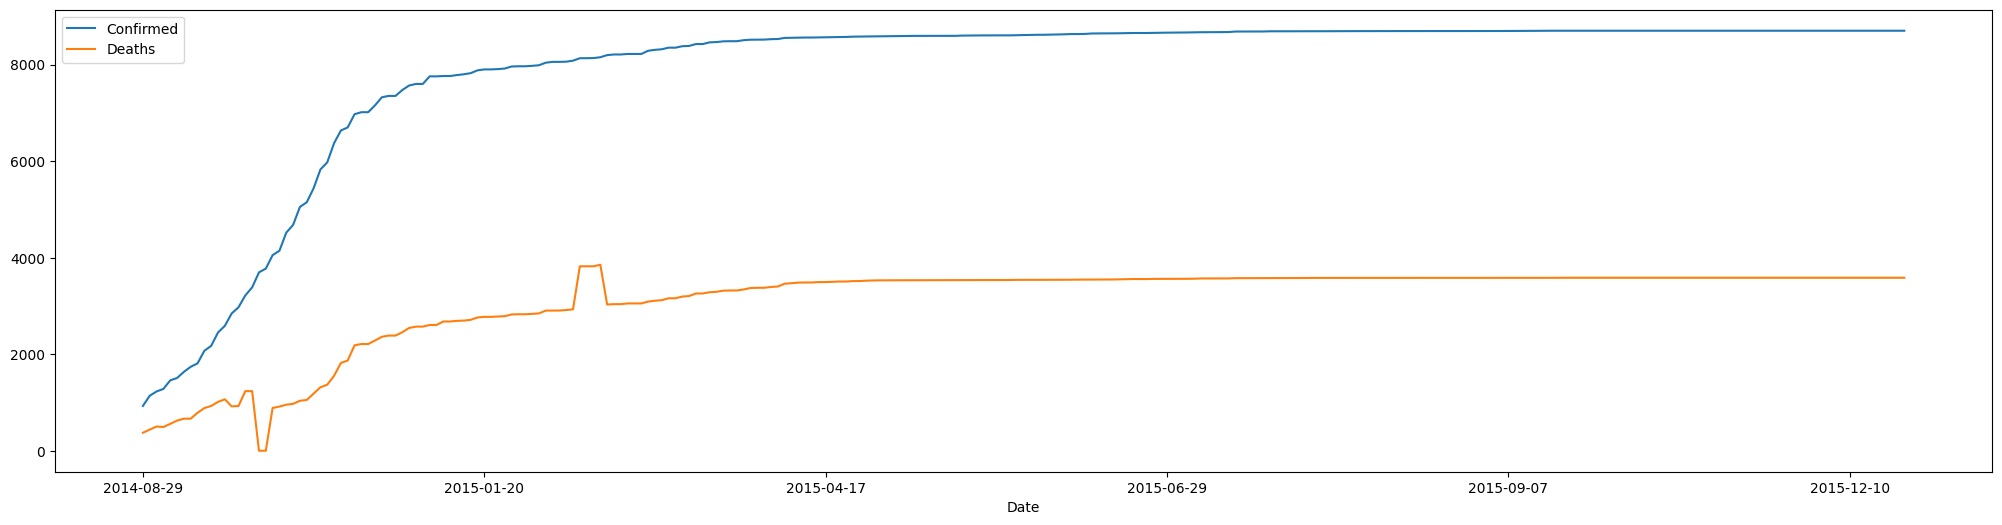

In [17]:
# plotting the number of case per day across the dataset
ebola_per_day.plot(kind='line', figsize = (25, 6))

<Axes: xlabel='Date'>

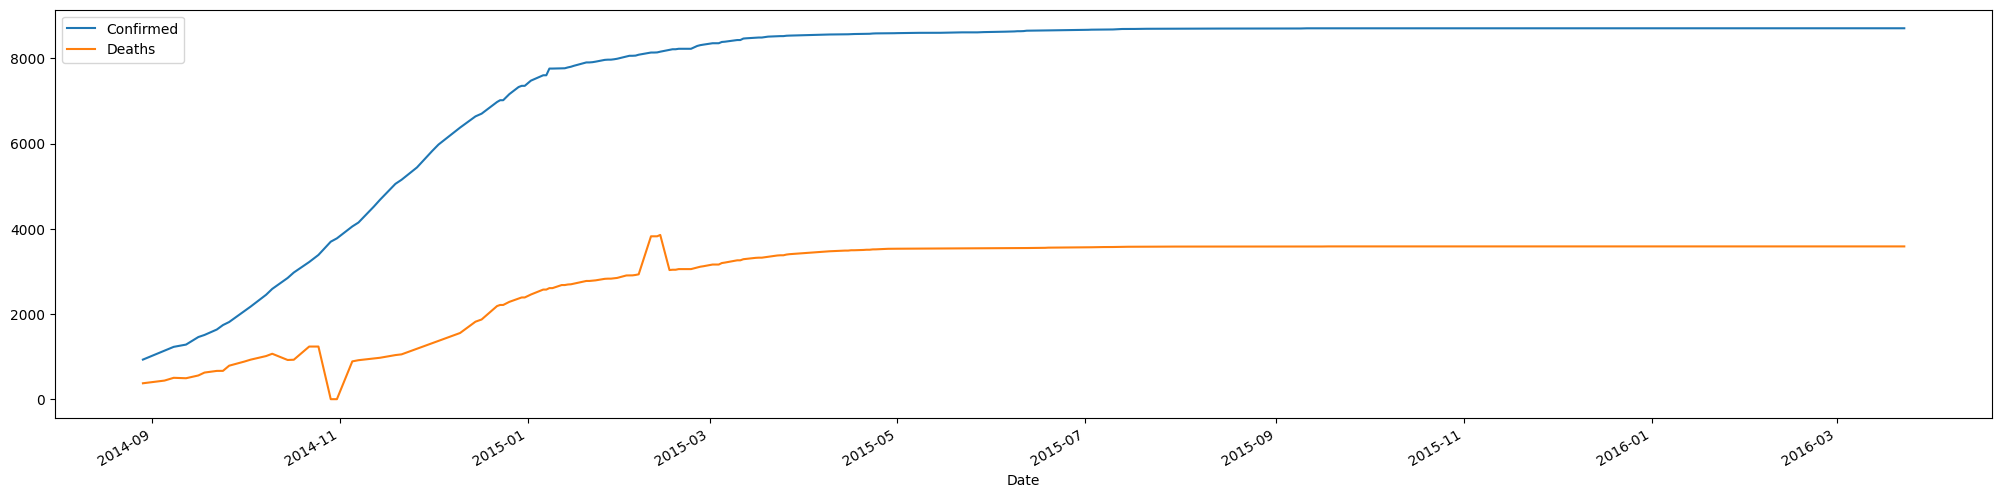

In [18]:
# displaying the entirety of the dataset
import datetime as dt
ebola = ebola_data.copy()
ebola['Date'] = pd.to_datetime(ebola['Date'])
ebola = ebola.set_index('Date')
ebola = ebola.loc['2014-08-29':'2016-03-29']
ebola_per_day = ebola.groupby('Date')[['Confirmed', 'Deaths']].max()
ebola_per_day.plot(kind='line', figsize = (25, 6))

In [19]:
# most affected countries
ebola_countries = ebola_data.groupby('Country/Region')[['Confirmed', 'Deaths']].max()
ebola_countries

,Confirmed,Deaths
Country/Region,,
Guinea,3351.0,2083.0
Italy,1.0,0.0
Liberia,3153.0,3858.0
Mali,7.0,5.0
Nigeria,19.0,7.0
Senegal,1.0,0.0
Sierra Leone,8704.0,3589.0
Spain,1.0,0.0
US,4.0,1.0


In [20]:
print(ebola['Country/Region'].value_counts())
# number of countries affected
print(len(ebola['Country/Region'].unique()))

Country/Region
Liberia           365
Guinea            259
Sierra Leone      259
Nigeria           255
Senegal           254
US                245
Spain             243
Mali              243
United Kingdom    221
Italy             141
Name: count, dtype: int64
10


<Axes: title={'center': 'Bar chart of countries with the highest number of deaths'}, xlabel='Country/Region'>

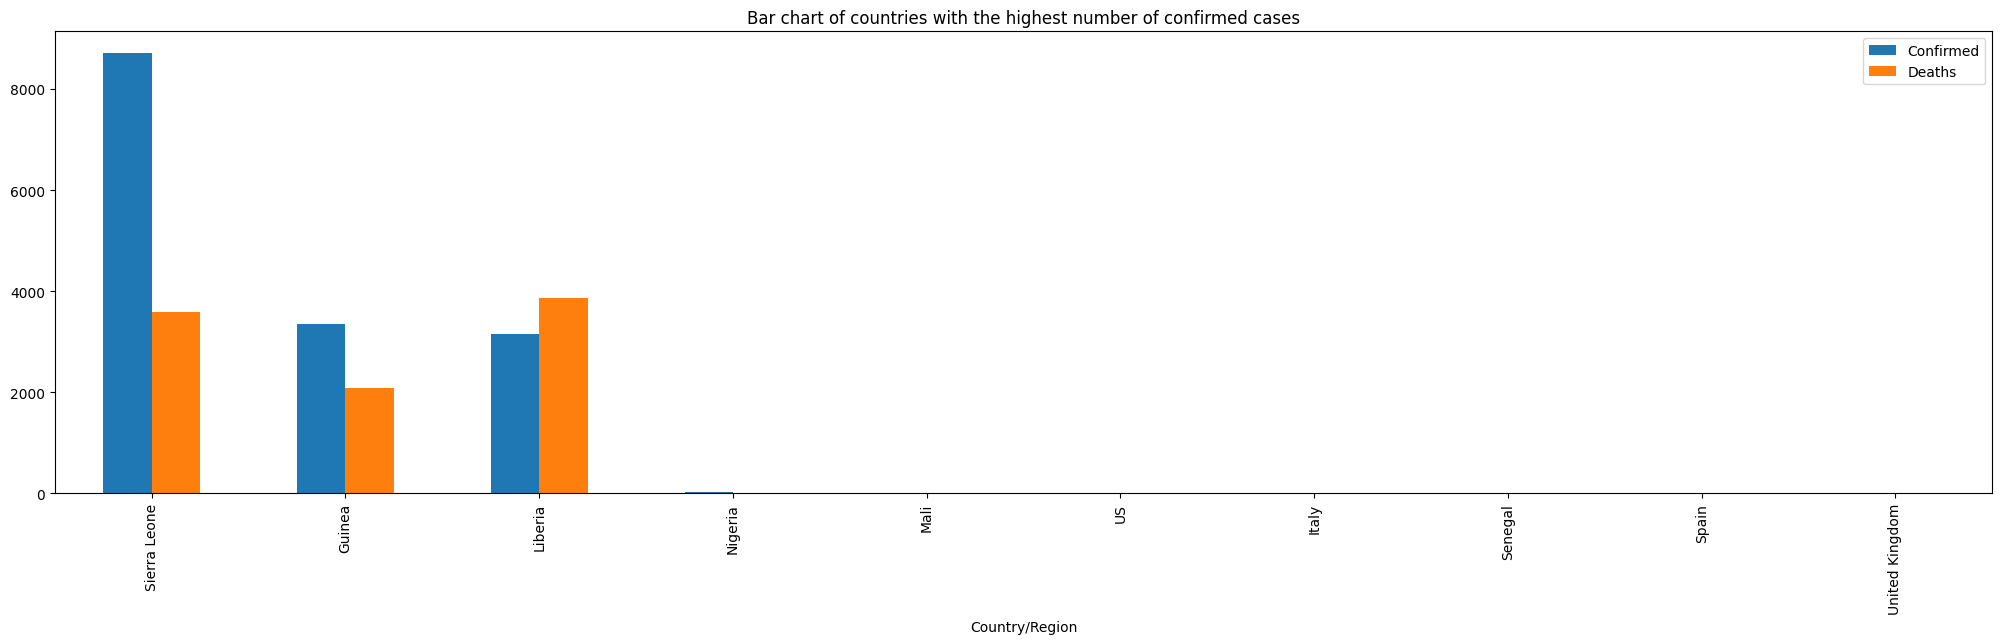

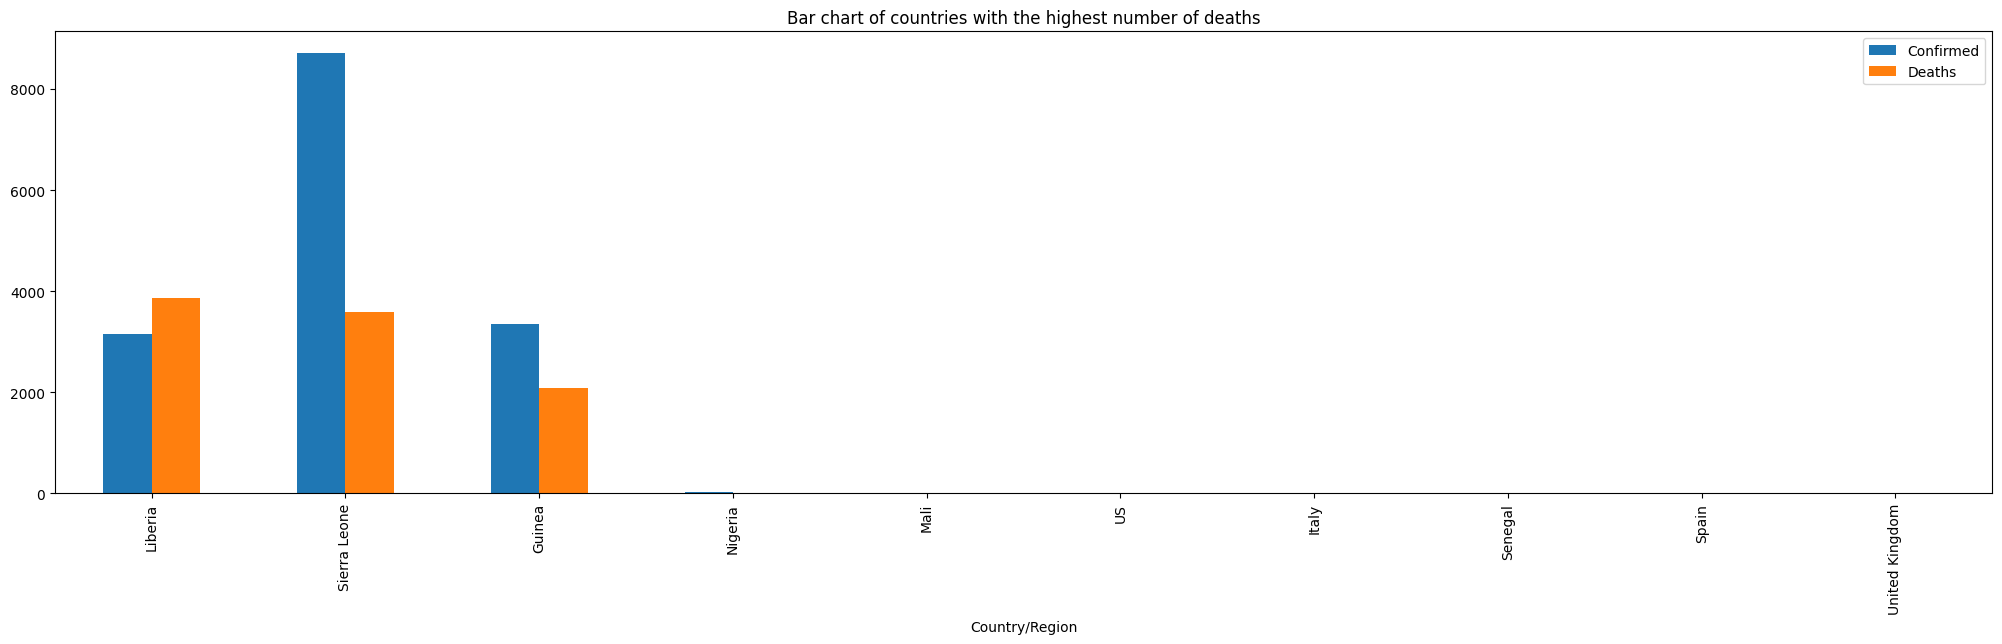

In [21]:
ebola_countries.nlargest(10, 'Confirmed').plot(kind='bar', figsize = (25, 6), title = 'Bar chart of countries with the highest number of confirmed cases')
ebola_countries.nlargest(10, 'Deaths').plot(kind='bar', figsize = (25, 6), title = 'Bar chart of countries with the highest number of deaths')

<Axes: ylabel='count'>

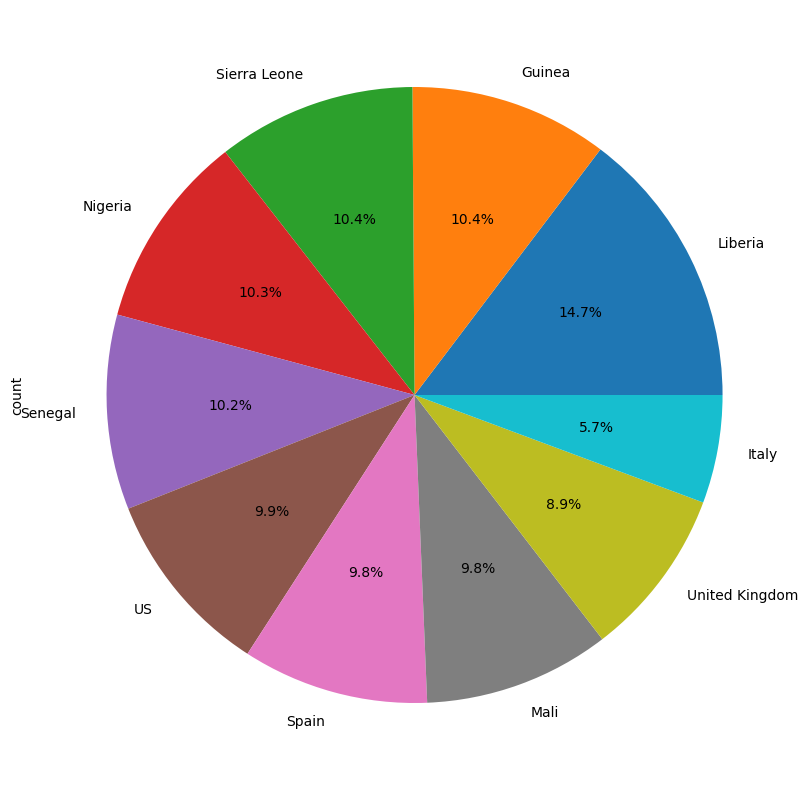

In [22]:
# pie chart visual of countries with ebola cases
ebola['Country/Region'].value_counts().plot.pie(autopct='%1.1f%%', figsize = (15, 10)) 

In [23]:
# Geographic distribution of ebola cases
ebola_geo = gpd.GeoDataFrame(ebola, geometry=gpd.points_from_xy(ebola['Long'], ebola['Lat']))
ebola_geo

,Country/Region,Confirmed,Deaths,Lat,Long,geometry
Date,,,,,,
2014-08-29,Guinea,482.0,287.0,9.945600,-9.696600,POINT (-9.6966 9.9456)
2014-08-29,Nigeria,15.0,6.0,9.082000,8.675300,POINT (8.6753 9.082)
2014-08-29,Sierra Leone,935.0,380.0,8.460555,-11.779889,POINT (-11.77989 8.46056)
2014-08-29,Liberia,322.0,225.0,6.428100,-9.429500,POINT (-9.4295 6.4281)
2014-09-05,Sierra Leone,1146.0,443.0,8.460555,-11.779889,POINT (-11.77989 8.46056)
...,...,...,...,...,...,...
2016-03-23,Liberia,3151.0,NaN,6.428100,-9.429500,POINT (-9.4295 6.4281)
2016-03-23,Italy,1.0,NaN,43.000000,12.000000,POINT (12 43)
2016-03-23,Liberia,2.0,1.0,6.428100,-9.429500,POINT (-9.4295 6.4281)


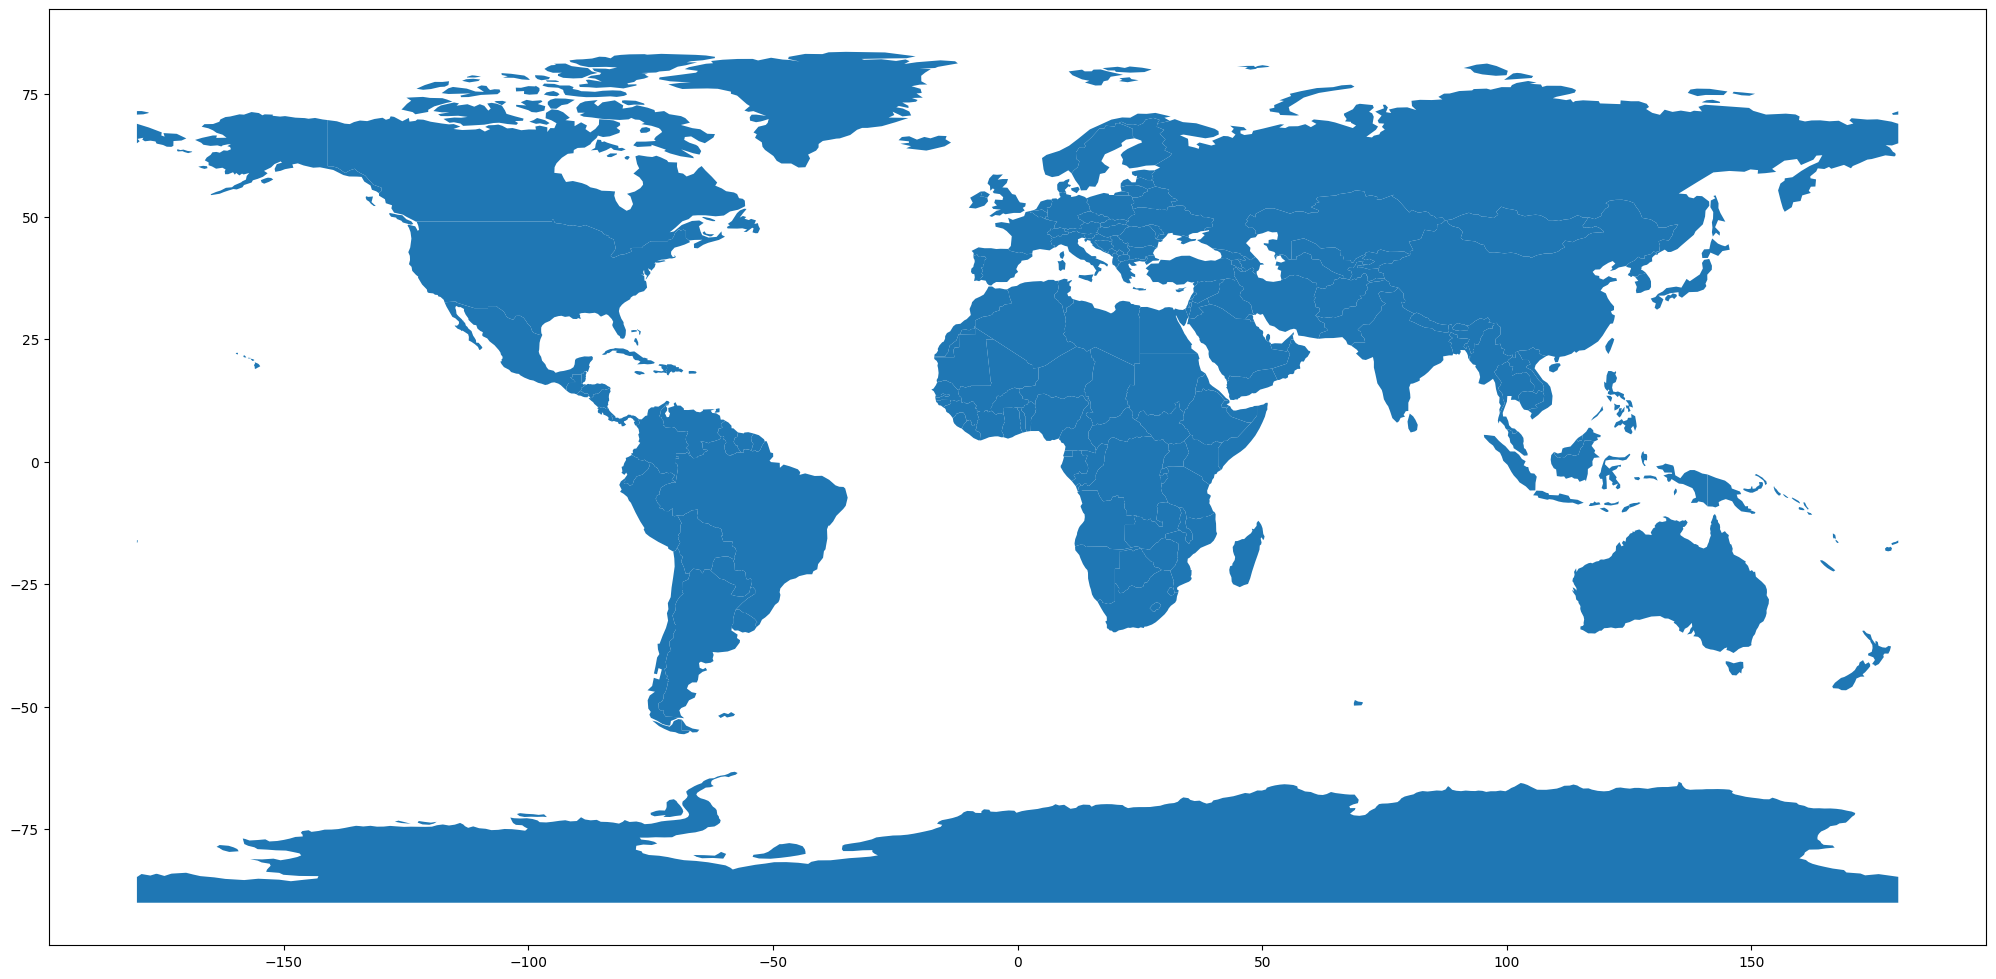

<Axes: >

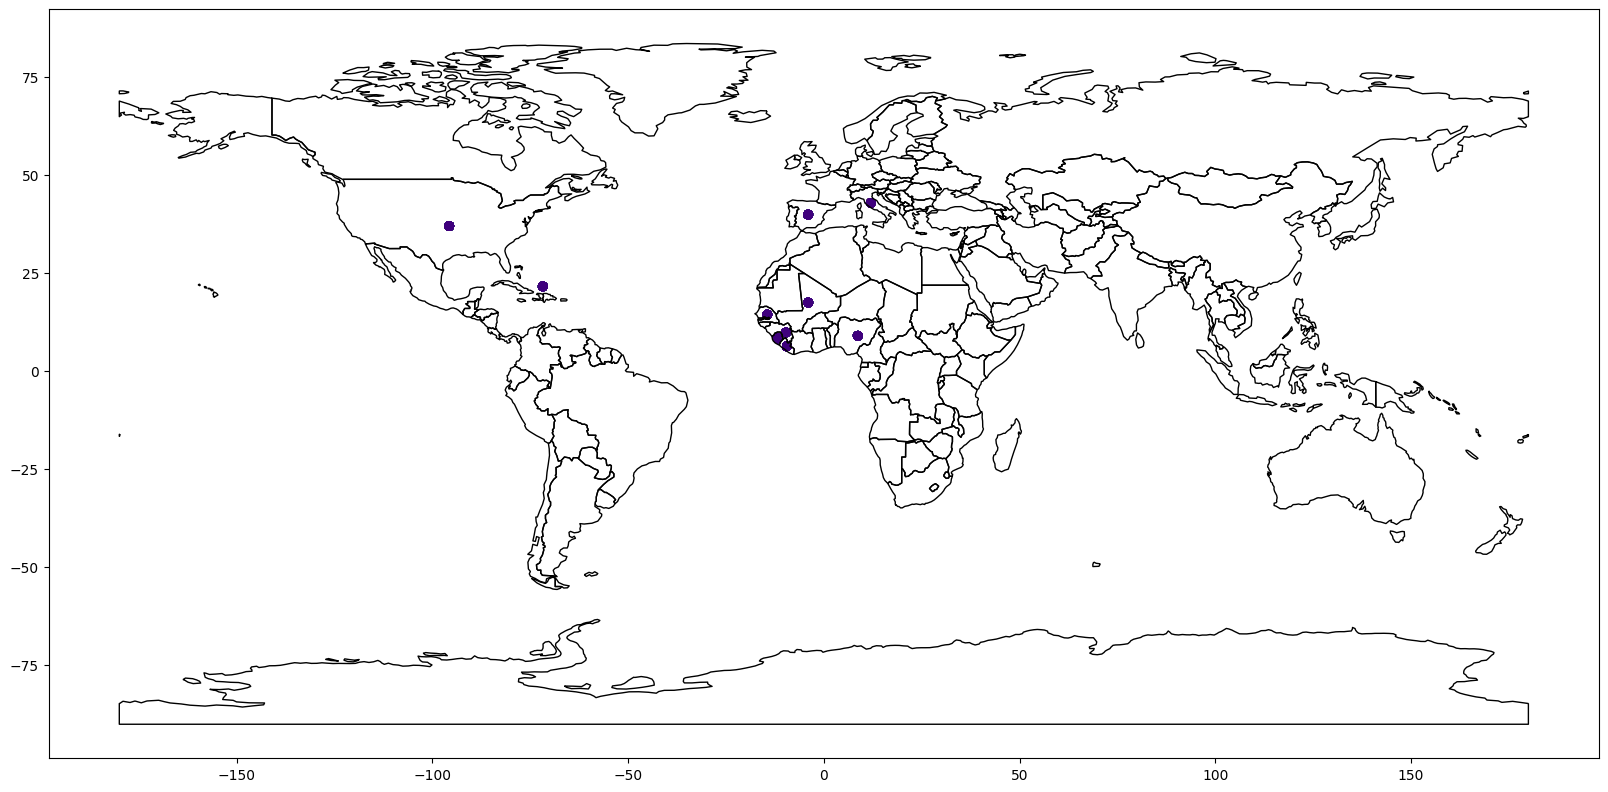

In [25]:
fig,ax = plt.subplots(figsize=(20, 10))
ebola_geo.plot(cmap ='Purples', ax=ax)
world.geometry.boundary.plot(color=None, edgecolor='k', linewidth = 1, ax=ax)

In [26]:
#total confirmed cases in each country
ebola_country = ebola.groupby('Country/Region')[['Confirmed', 'Deaths']].max()
ebola_country


,Confirmed,Deaths
Country/Region,,
Guinea,3351.0,2083.0
Italy,1.0,0.0
Liberia,3153.0,3858.0
Mali,7.0,5.0
Nigeria,19.0,7.0
Senegal,1.0,0.0
Sierra Leone,8704.0,3589.0
Spain,1.0,0.0
US,4.0,1.0
